# Sistema de Recomendação

Este notebook apresenta algumas implementações de sistema de recomendação utilizando
o dataset Movielens.
Este notebook contém:
- Modelo de Sistema de Recomendação utilizando atributos latentes e produto interno
- Modelo utilizando atributos latentes concatenados e uma rede neural
- Calcula a predição para todos os filmes e usuários que não fizeram suas avaliações
- Visualiza a matriz de avaliações por usuários x filmes com todas as predições
- Análise do significado dos embeddings

Obs: Este notebook foi inspirado em exemplo divulgado pelo no [fast.ai](http://fast.ai)

## Importação da bibliotecas

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import keras
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input, Embedding
from keras.models import Model
from keras.regularizers import l2
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam

np.set_printoptions(formatter={'float': '{: 0.1f}'.format})


## Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


### Leitura dos Dados - Movielens dataset

Caso a célula a seguir falhar, é necessário executar o notebook:
- [Movielens Dataset](MovieLens_dataset.ipynb) que é responsável por ler o dataset original e
prepará-lo para este notebook

Este dataset consiste de:
- 100.004 avaliações de filmes (amostras), feitas por
- 671 usuários, sobre
- 9066 filmes

As amostras estão no array `ratings` organizados da seguinte forma:
- cada linha é uma amostra
- coluna 0 é o iD do usuário
- coluna 1 é o iD do filme
- coluna 2 é a avaliação do usuários entre 0.0 e 5.0

In [78]:
data = np.load('../data/movielens_ordered.npz')
ratings = data['ratings']
movie_names = data['movie_names']
n_samples = ratings.shape[0]
print('n_samples:',n_samples)
print('ratings:\n', ratings[:5])

n_samples: 100004
ratings:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]


In [80]:
for i in (ratings[:5,1]).astype(np.int):
    print(movie_names[i])

Dangerous Minds (1995)
Dumbo (1941)
Sleepers (1996)
Escape from New York (1981)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [81]:
h_userId = np.bincount(ratings[:,0].astype(np.int))
n_users = h_userId.size
h_movieId = np.bincount(ratings[:,1].astype(np.int))
n_movies = h_movieId.size
print('n_users:',n_users)
print('n_movies:',n_movies)

n_users: 671
n_movies: 9066


## Divisão dos dados em treinamento e validação

In [82]:
np.random.seed = 42

Faz a divisão com 80% das amostras para treinamento e 20% para validação:

In [83]:
msk = np.random.rand(n_samples) < 0.8
train = ratings[msk]
valid = ratings[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 80288  amostras:
 [[ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]
 [ 0.0  1041.0  2.0]]
valid: 19716  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  1017.0  2.0]
 [ 0.0  1083.0  3.5]
 [ 0.0  1111.0  2.5]
 [ 0.0  1140.0  1.0]]


This is the number of latent factors in each embedding.

In [84]:
n_factors = 50

## Primeira solução - usando produto interno: Dot

<img src='../figures/Recomendacao_dot.png', width=600ptx></img>

O primeiro modelo é o produto interno entre os atributos latentes dos usuários e dos filmes.
Este produto interno é implementado pela operação `dot` do Keras. Como o modelo agora não é
sequencial, há necessidade de utilizarmos o modelo API:

In [85]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, 
              input_length=1, 
              embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, 
              input_length=1, 
              embeddings_regularizer=l2(1e-4))(movie_in)
x = keras.layers.dot([u, m],axes=-1)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 1, 50)         33550                                        
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, 1, 50)         453300                                       
___________________________________________________________________________________________

In [86]:
model.compile(Adam(0.001), loss='mse')
model.fit([train_userId, train_movieId], train_rating, 
          batch_size=64, epochs=1, 
          validation_data=([valid_userId, valid_movieId], valid_rating))

Train on 79959 samples, validate on 20045 samples
Epoch 1/1
79959/79959 [==============================] - 27s - loss: 10.0468 - val_loss: 4.3488

Os bons modelos [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

### Predição de usuário e filme

Para calcular qualquer predição de qualquer usuário e qualquer filme, usa-se o `predict` do modelo treinado:

In [87]:
model.predict([np.array([3]), np.array([6])])

array([[ 3.2]], dtype=float32)

##  Usado Rede Neural

<img src='../figures/Recomendacao_NN.png', width=600ptx></img>

Uma solução usando rede neural é concatenar a saída dos embeddings e em seguida colocar uma camada densa
antes da última camada de um neurônio. No exemplo a seguir foi utilizado uma camada de 70 neurônios.

In [88]:
user_in = Input(shape=(1,),dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, 
              embeddings_regularizer=l2(1e-4))(user_in)

movie_in = Input(shape=(1,),dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, 
              embeddings_regularizer=l2(1e-4))(movie_in)

In [89]:
x = keras.layers.concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
model_nn = Model([user_in, movie_in], x)
print(model_nn.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550                                        
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300                                       
___________________________________________________________________________________________

In [91]:
nn.compile(Adam(0.001), loss='mse')
nn.fit([train_userId, train_movieId], train_rating, batch_size=64, epochs=1, # was 8 
          validation_data=([valid_userId, valid_movieId], valid_rating))

Train on 79959 samples, validate on 20045 samples
Epoch 1/1
79959/79959 [==============================] - 30s - loss: 0.8522 - val_loss: 0.8088

Com esta rede, a perda já é bem melhor, comparável com os melhores sistemas de recomendação.

## Matriz de recomendações, por usuário e por filme

O sistema de recomendação pode ser visualizado por uma matriz onde as linhas sejam os
IDs dos usuários e as colunas sejam os IDs dos títulos dos filmes. Colocamos como -1
os elementos em que não existem avaliações. Esta matriz é bastante esparsa, pois existem
normalmente poucas avaliações feitas.

In [92]:
grid_ratings = -1. * np.ones((n_users,n_movies))
uId = (ratings[:,0]).astype(np.int)
mId = (ratings[:,1]).astype(np.int)
grid_ratings[uId,mId] = ratings[:,2] # Criação da matriz
print(grid_ratings.shape)

(671, 9066)


### Visualização da matriz de recomendações, original

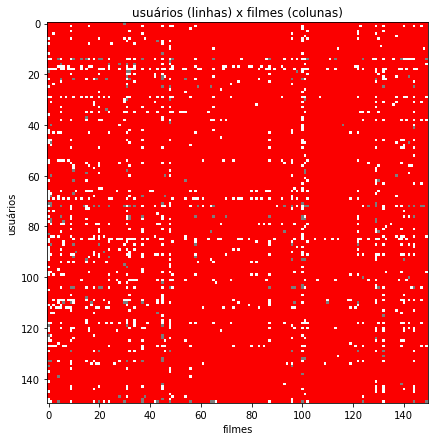

In [93]:
show_ratings = np.zeros((n_users,n_movies,3))
show_ratings[:,:,0] = np.where(grid_ratings == -1., 5, grid_ratings)
show_ratings[:,:,1] = np.where(grid_ratings == -1., 0., grid_ratings)
show_ratings[:,:,2] = np.where(grid_ratings == -1., 0., grid_ratings)


import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(show_ratings[:150,:150,:])
plt.xlabel('filmes')
plt.ylabel('usuários')
plt.show()

## Predições para todos os usuários e filmes

In [94]:
n2p_user,n2p_movie = np.nonzero(grid_ratings==-1)
recommend = nn.predict([n2p_user, n2p_movie])

### Montagem da matriz de recomendação "cheia"

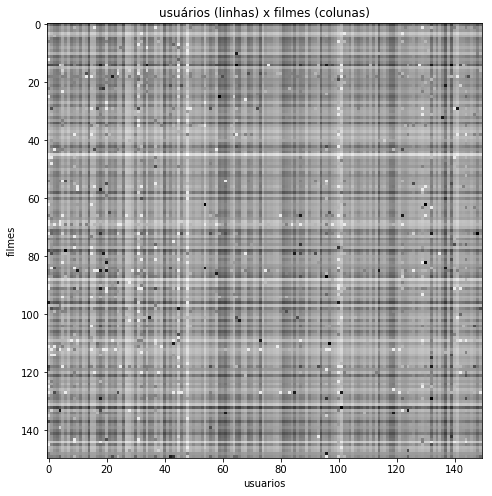

In [95]:
gg = grid_ratings.copy()
gg[n2p_user,n2p_movie] = recommend[:,0]

plt.figure(figsize=(8,8))
plt.title('usuários (linhas) x filmes (colunas)')
plt.xlabel('usuarios')
plt.ylabel('filmes')
plt.imshow(gg[:150,:150],cmap='gray')
plt.show()

### Visualização de uma parte da matriz

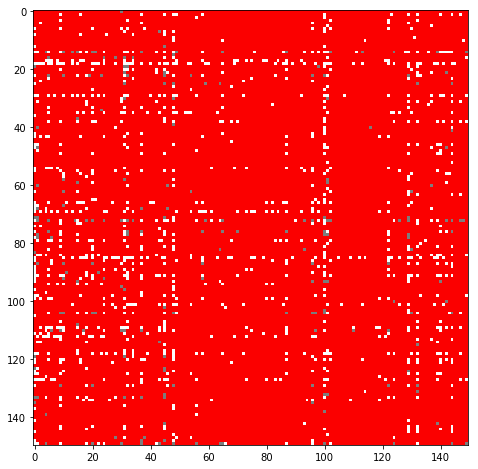

In [96]:
plt.figure(figsize=(8,8))
plt.imshow(show_ratings[:150,:150,:])

### Visualização da parte de usuários mais ativos e filmes mais populares

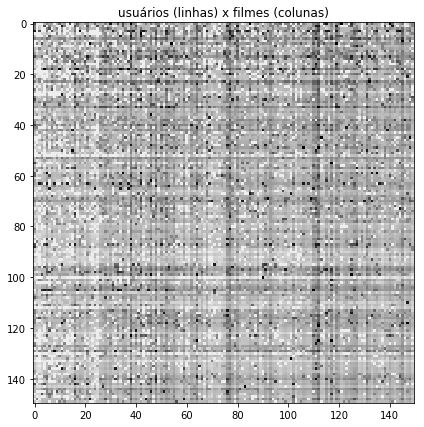

In [97]:
io_popular_movies = np.argsort(h_movieId)[::-1]
io_top_users = np.argsort(h_userId)[::-1].astype(np.int)
gg_ord = gg[np.ix_(io_top_users,io_popular_movies)]
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[:150,:150],cmap='gray')
plt.show()

### Visualização dos usuários menos ativos e filmes menos avaliados

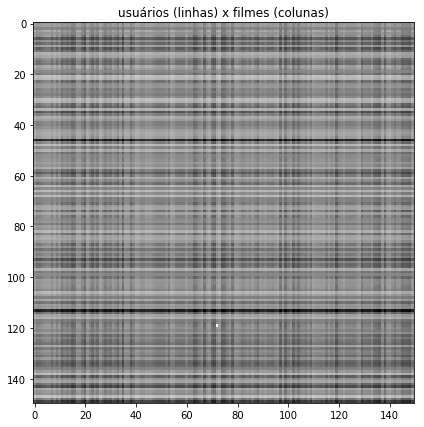

In [98]:
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[-150:,-150:],cmap='gray')
plt.show()

## Analise dos embeddings dos filmes

A análise a seguir será feita apenas com os 2000 filmes mais populares:

In [99]:
topMovies = io_popular_movies[:2000]

### Extração dos atributos latentes (embeddings) dos 2000 fimes mais populares

Para obter os atributos latentes dos 2000 filmes mais populares, primeiro criamos uma
nova rede, denominada `get_movie_emb`, a partir da rede `Model`, com a entrada apenas o ID dos filmes e
a saída `m`, após o embedding. Aplicamos a predição desta rede nos `topMovies`:

In [100]:
get_movie_emb = Model(movie_in, m)
m_emb = get_movie_emb.predict([topMovies])
movie_emb = np.squeeze(m_emb) # elimina dimensões 1
print(m_emb.shape)
movie_emb.shape

(2000, 1, 50)


(2000, 50)

Como o embedding de cada filme tem dimensão 50, é muito difícil conseguir analisá-lo desta forma.
Uma forma muito usual é reduzir esta dimensionalidade utilizando uma técnica denominada PCA -
Principal Component Analysis: [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/).
Iremos reduzir a dimensão dos embeddings de 50 para 3. 

In [101]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

#### Filmes com alto valor na primeira dimensão do PCA

In [102]:
fac0 = movie_pca[0]
isort = np.argsort(fac0)[::-1]

for ii in isort[:15]:
    print(fac0[ii],movie_names[ii])

0.068637966885 White Squall (1996)
0.0670189428384 Scream 2 (1997)
0.0638019088485 Best Years of Our Lives, The (1946)
0.0598002763539 Glimmer Man, The (1996)
0.0584681851414 Without Limits (1998)
0.0582279634655 Edge, The (1997)
0.0579181191052 Rich Man's Wife, The (1996)
0.0566169711814 He Got Game (1998)
0.0547972202351 Playing by Heart (1998)
0.0540984972997 G.I. Jane (1997)
0.0540248807839 Prefontaine (1997)
0.053851070355 Warriors of Virtue (1997)
0.0532237494096 Land Before Time III: The Time of the Great Giving (1995)
0.0531962322386 Gremlins (1984)
0.0530864351728 Matilda (1996)


#### Filmes com baixo valor na primeira dimensão do PCA

In [103]:
for ii in isort[-15:]:
    print(fac0[ii],movie_names[ii])

-0.054121124998 Jumanji (1995)
-0.0551192355023 Walking and Talking (1996)
-0.055415784617 Paradise Road (1997)
-0.0560552719299 Cabin Boy (1994)
-0.0568471133631 Paradine Case, The (1947)
-0.0590702522901 Before and After (1996)
-0.0591380983925 Love and Other Catastrophes (1996)
-0.0599548509783 Phat Beach (1996)
-0.0612669359776 Reluctant Debutante, The (1958)
-0.0615334980217 Lethal Weapon 3 (1992)
-0.064699186536 Drop Zone (1994)
-0.0654661857928 Pretty in Pink (1986)
-0.0668779755403 Streetcar Named Desire, A (1951)
-0.0812836299876 Zero Effect (1998)
-0.0912226188663 Underworld (1996)


### Análise da segunda dimensão do PCA

In [104]:
fac1 = movie_pca[1]
isort = np.argsort(fac1)[::-1]

#### Mais bem avaliados na segunda dimensão

In [106]:
for ii in isort[:15]:
    print(fac1[ii],movie_names[ii])

0.0720401887425 Jungle2Jungle (a.k.a. Jungle 2 Jungle) (1997)
0.0643632923495 McHale's Navy (1997)
0.0642386947525 Up Close and Personal (1996)
0.0617852947982 I Love Trouble (1994)
0.059360147616 How to Make an American Quilt (1995)
0.0589028549296 Big One, The (1997)
0.0586057869467 Six Days Seven Nights (1998)
0.0582985452705 Cutthroat Island (1995)
0.0568682148204 Crimson Tide (1995)
0.056832764377 Man Who Knew Too Much, The (1934)
0.0554424610543 I Went Down (1997)
0.054099622783 Under Capricorn (1949)
0.0534252957841 Air Bud: Golden Receiver (1998)
0.0533097196511 Rear Window (1954)
0.0530022370678 Hellraiser: Bloodline (1996)


#### Piores avaliados na segunda dimensão

In [107]:
for ii in isort[-15:]:
    print(fac1[ii],movie_names[ii])

-0.0521559031065 Congo (1995)
-0.0523772127221 Ugly, The (1997)
-0.0526911217921 Rain Man (1988)
-0.0536118776091 Walkabout (1971)
-0.0551748668232 Albino Alligator (1996)
-0.0553281355453 Suture (1993)
-0.055700881241 Beautician and the Beast, The (1997)
-0.0569966006001 Omen, The (1976)
-0.0581324897855 Timecop (1994)
-0.0581736927076 Clean Slate (1994)
-0.0603497803743 Sound of Music, The (1965)
-0.0633469806656 Sneakers (1992)
-0.0642355285741 Wild Reeds (Les roseaux sauvages) (1994)
-0.0651898340219 Evita (1996)
-0.0656815365386 Mighty, The (1998)


### Análise da terceira dimensão do PCA

In [108]:
fac2 = movie_pca[2]
isort = np.argsort(fac2)[::-1]

#### Mais bem avaliados na terceira dimensão do PCA

In [111]:
for ii in isort[:15]:
    print(fac2[ii],movie_names[ii])

0.0658461799949 Batman (1989)
0.0597537026732 People vs. Larry Flynt, The (1996)
0.0584476096321 Deconstructing Harry (1997)
0.058036919549 Arsenic and Old Lace (1944)
0.0574461570016 Garbage Pail Kids Movie, The (1987)
0.056762181723 Swan Princess, The (1994)
0.0562545006913 Double Life of Veronique, The (Double Vie de Véronique, La) (1991)
0.0541121407592 Lady Vanishes, The (1938)
0.0535526412204 Mass Appeal (1984)
0.053026342344 Yes, Madam (a.k.a. Police Assassins) (a.k.a. In the Line of Duty 2) (Huang gu shi jie) (1985)
0.0527383093412 Toys (1992)
0.0526769973675 Quiet Man, The (1952)
0.0525127261632 Die Hard (1988)
0.0522711431663 Microcosmos (Microcosmos: Le peuple de l'herbe) (1996)
0.0521749071589 Child's Play 3 (1991)


#### Piores avaliados na terceira dimensão do PCA

In [112]:
for ii in isort[-15:]:
    print(fac2[ii],movie_names[ii])

-0.0533547328872 Vampire in Brooklyn (1995)
-0.0541399009826 Gabbeh (1996)
-0.0556542620775 Mulholland Falls (1996)
-0.056201253018 Tomorrow Never Dies (1997)
-0.0563148477513 Othello (1995)
-0.0579255295483 Lord of the Rings, The (1978)
-0.0610447904296 Trigger Effect, The (1996)
-0.0618494635869 Meet Me in St. Louis (1944)
-0.0620792238238 Palookaville (1996)
-0.0623565831148 Some Like It Hot (1959)
-0.0635709867475 Heartbreak Ridge (1986)
-0.0654869497597 Merry War, A (1997)
-0.0658970765183 Love Affair (1994)
-0.0715517674174 Manhattan (1979)
-0.0773246697135 Broadcast News (1987)


### Visualizando duas dimensões do PCA

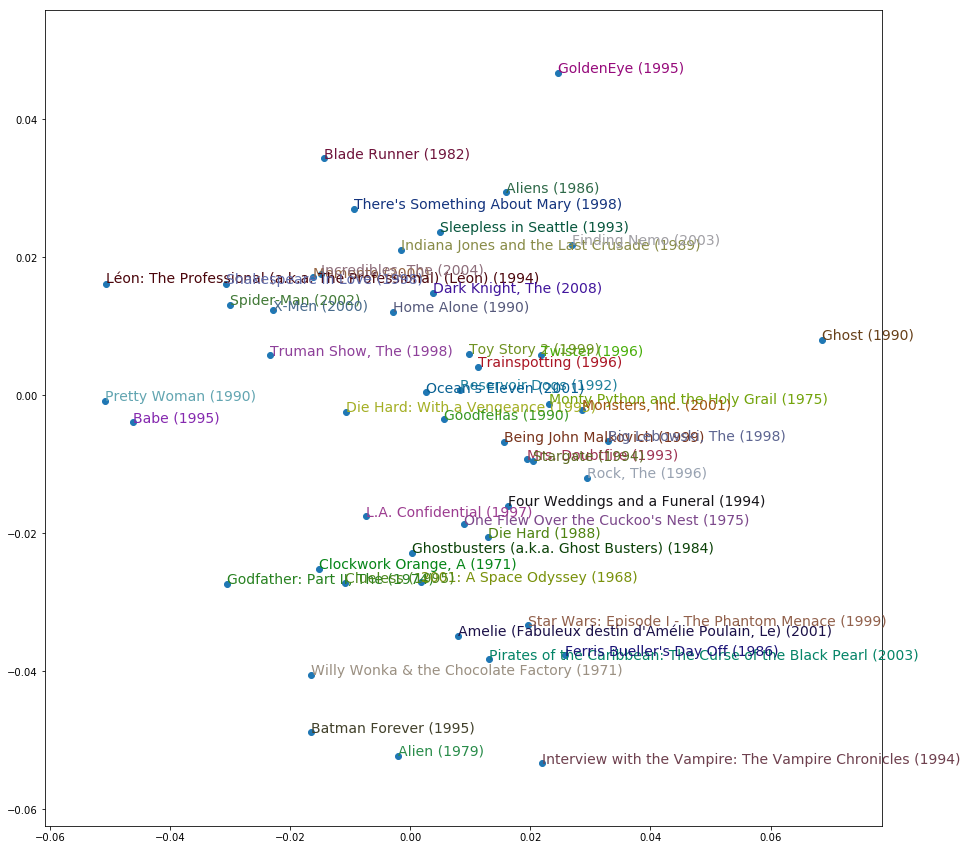

In [113]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Exercícios

1. Inclua um novo usuário, sem nenhuma avaliação. Treine a rede e verifique
   se após a rede treinada, se haverá alguma avaliação.
2. Com o novo usuário, faça uma única avaliação e verifique quais os 10 filmes
   mais recomendados para ele.

## Aprendizados com este notebook